#Necessary libraries

In [12]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import scipy.cluster.hierarchy as sch
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

#Data Exploration

In [13]:
# Load the dataset
data = pd.read_csv('/content/RW data1.csv')

# Basic Data Exploration
print("Data Shape:", data.shape)
print("Data Columns:", data.columns)
print(data.describe())
print(data.info())


Data Shape: (2125, 247)
Data Columns: Index(['__exception__', 'bind', 'certopenstore', 'closesocket',
       'cocreateinstance', 'cocreateinstanceex', 'cogetclassobject',
       'coinitializeex', 'coinitializesecurity', 'connect',
       ...
       'wsarecv', 'wsarecvfrom', 'wsasendto', 'wsasocketa', 'wsasocketw',
       'wsastartup', 'getaddrinfow', 'thread32first', 'thread32next', 'Label'],
      dtype='object', length=247)
       __exception__         bind  certopenstore  closesocket  \
count    2125.000000  2125.000000    2125.000000  2125.000000   
mean       -0.130493     0.247511      -0.125402    -0.014721   
std         0.004230     0.005717       0.000354     0.004031   
min        -0.145452     0.224728      -0.126867    -0.027757   
25%        -0.133197     0.243855      -0.125638    -0.017206   
50%        -0.130633     0.247554      -0.125386    -0.015007   
75%        -0.128029     0.251195      -0.125133    -0.012817   
max        -0.111138     0.268534      -0.124020  

In [14]:
# Checking for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])


Missing values in each column:
 Series([], dtype: int64)


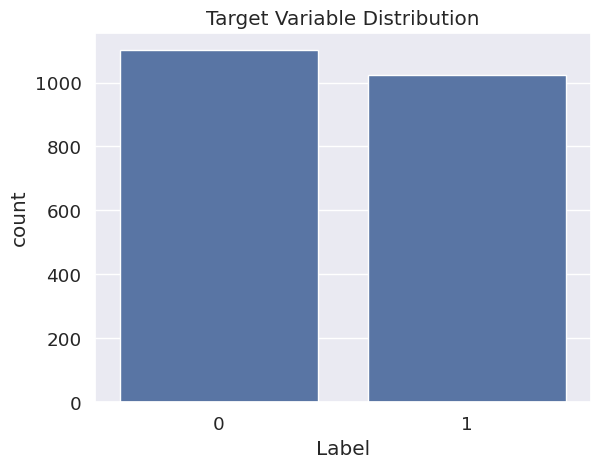

In [15]:
# Visualizing distributions and correlations
sns.countplot(x='Label', data=data)
plt.title('Target Variable Distribution')
plt.show()


<Figure size 1500x1000 with 0 Axes>

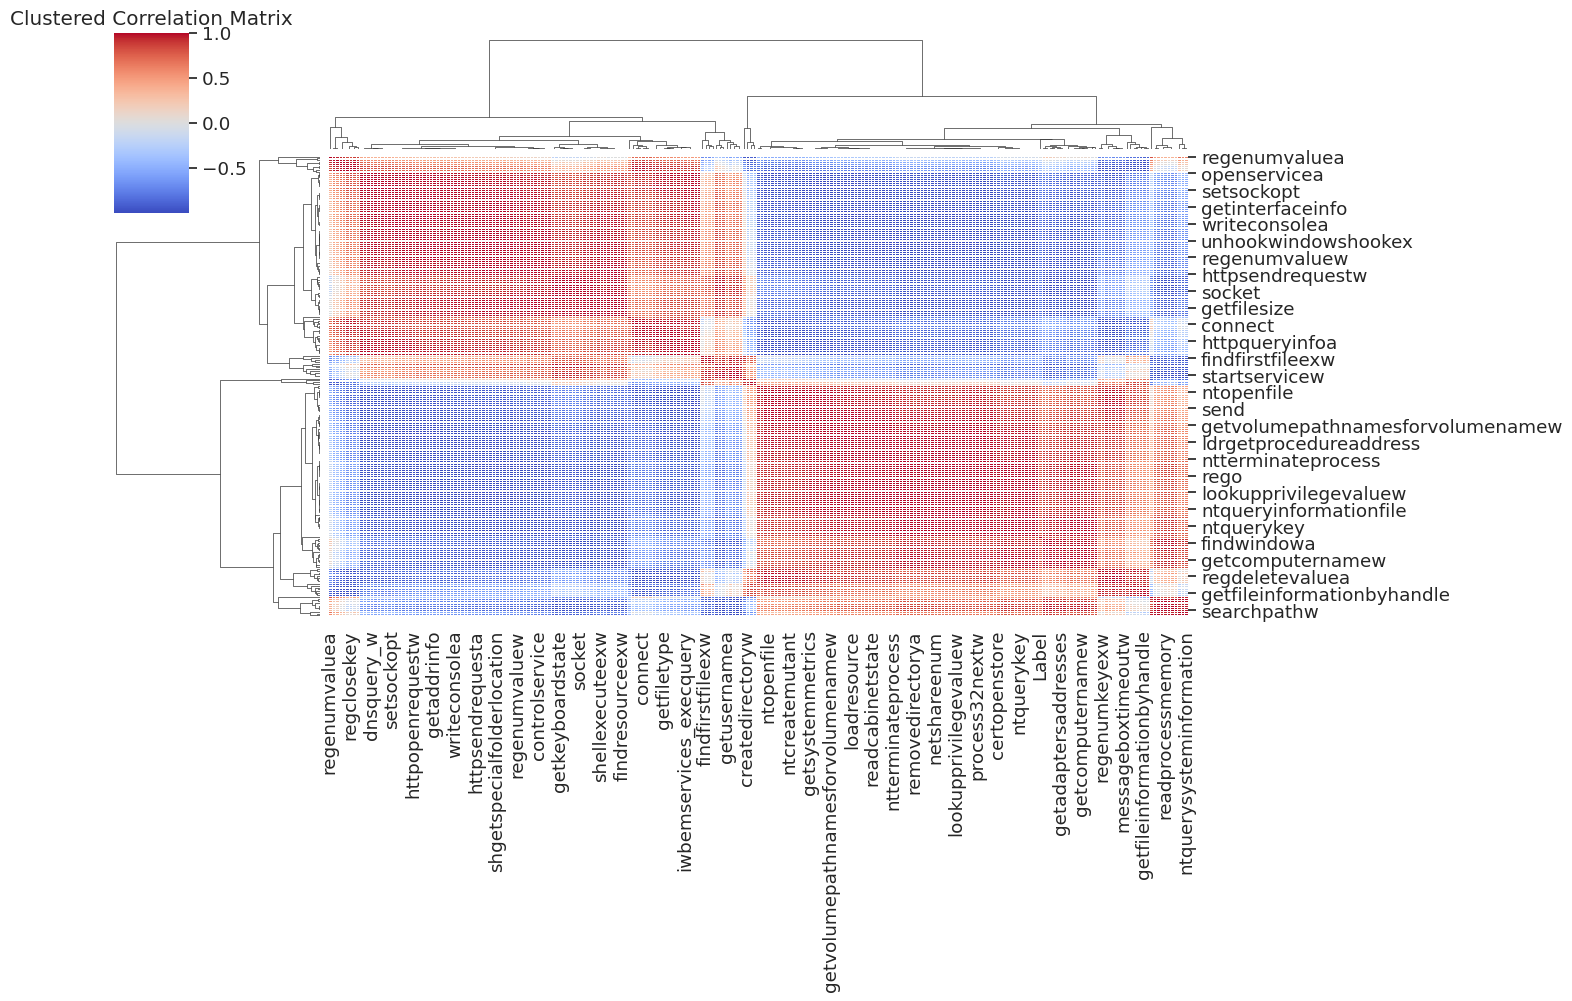

In [16]:
corr_matrix = data.corr()

# Cluster the correlation matrix
plt.figure(figsize=(15, 10))
sns.clustermap(corr_matrix, cmap="coolwarm", linewidths=.5, annot=False, method="average", figsize=(15, 10))
plt.title("Clustered Correlation Matrix")
plt.show()


#Data Cleaning

In [17]:
# Handling Missing Values
data = data.dropna()

# Dropping Duplicates
data = data.drop_duplicates()

# Separating Features and Target
X = data.drop('Label', axis=1)
y = data['Label']

# Scaling the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



#Data Preparation

In [18]:
# Splitting Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Cross-validation setup with Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


#Modeling and Hyperparameter Tuning


In [19]:
# Define models with a pipeline to include scaling
models = {
    "RandomForest": make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42)),
    "SVC": make_pipeline(StandardScaler(), SVC(probability=True, random_state=42)),
    "KNeighbors": make_pipeline(StandardScaler(), KNeighborsClassifier())
}

# Evaluate models with cross-validation
results = {}
for name, model in models.items():
    y_pred = cross_val_predict(model, X_train, y_train, cv=skf)
    y_proba = cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

    # Store metrics for each model
    results[name] = {
        "Accuracy": accuracy_score(y_train, y_pred),
        "Precision": precision_score(y_train, y_pred),
        "Recall": recall_score(y_train, y_pred),
        "F1 Score": f1_score(y_train, y_pred),
        "AUC": roc_auc_score(y_train, y_proba)
    }

# Ensemble Model - Voting Classifier
ensemble_model = VotingClassifier(estimators=[(name, model.steps[-1][1]) for name, model in models.items()], voting='soft')
y_pred_ensemble = cross_val_predict(ensemble_model, X_train, y_train, cv=skf)
y_proba_ensemble = cross_val_predict(ensemble_model, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

# Store metrics for ensemble
results["Ensemble"] = {
    "Accuracy": accuracy_score(y_train, y_pred_ensemble),
    "Precision": precision_score(y_train, y_pred_ensemble),
    "Recall": recall_score(y_train, y_pred_ensemble),
    "F1 Score": f1_score(y_train, y_pred_ensemble),
    "AUC": roc_auc_score(y_train, y_proba_ensemble)
}


#Model Evaluation and Visualization

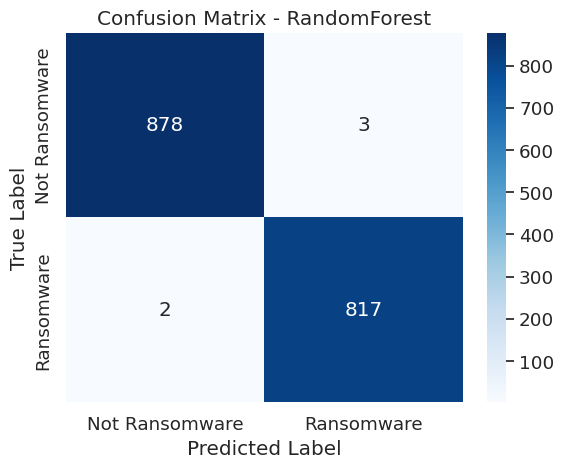

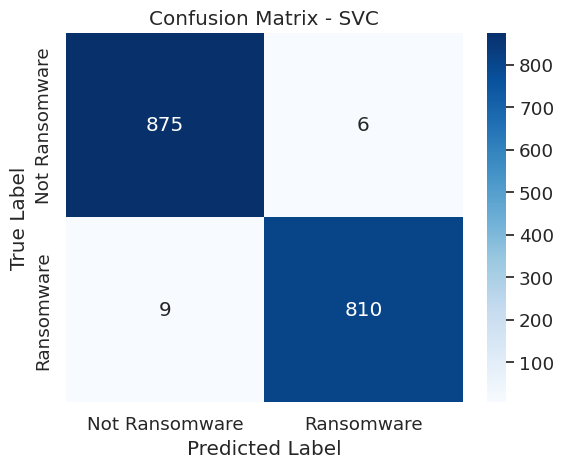

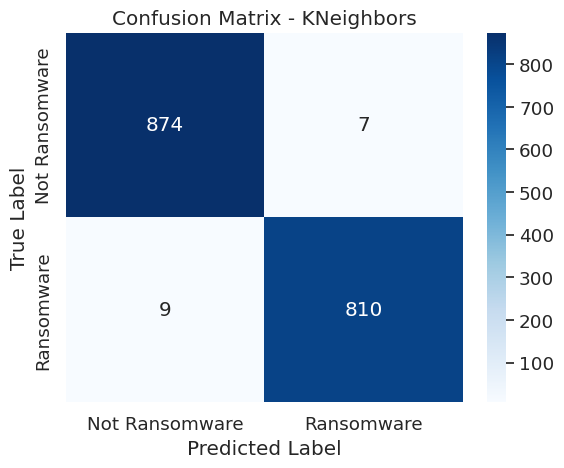

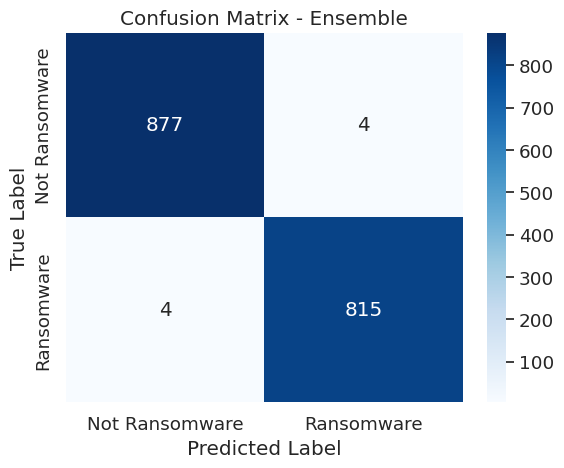

In [20]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Ransomware", "Ransomware"],
                yticklabels=["Not Ransomware", "Ransomware"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Plotting Confusion Matrices
for name, model in models.items():
    y_pred = cross_val_predict(model, X_train, y_train, cv=skf)
    plot_confusion_matrix(y_train, y_pred, f"Confusion Matrix - {name}")

# Plot confusion matrix for Ensemble
plot_confusion_matrix(y_train, y_pred_ensemble, "Confusion Matrix - Ensemble")


In [21]:

# Display the sorted results DataFrame
print("Model Performance Results:\n", summary_df)

Model Performance Results:
               Accuracy  Precision    Recall  F1 Score       AUC
RandomForest  0.997059   0.996341  0.997558  0.996949  0.999975
Ensemble      0.995294   0.995116  0.995116  0.995116  0.999935
KNeighbors    0.990588   0.991432  0.989011  0.990220  0.999803
SVC           0.991176   0.992647  0.989011  0.990826  0.999759


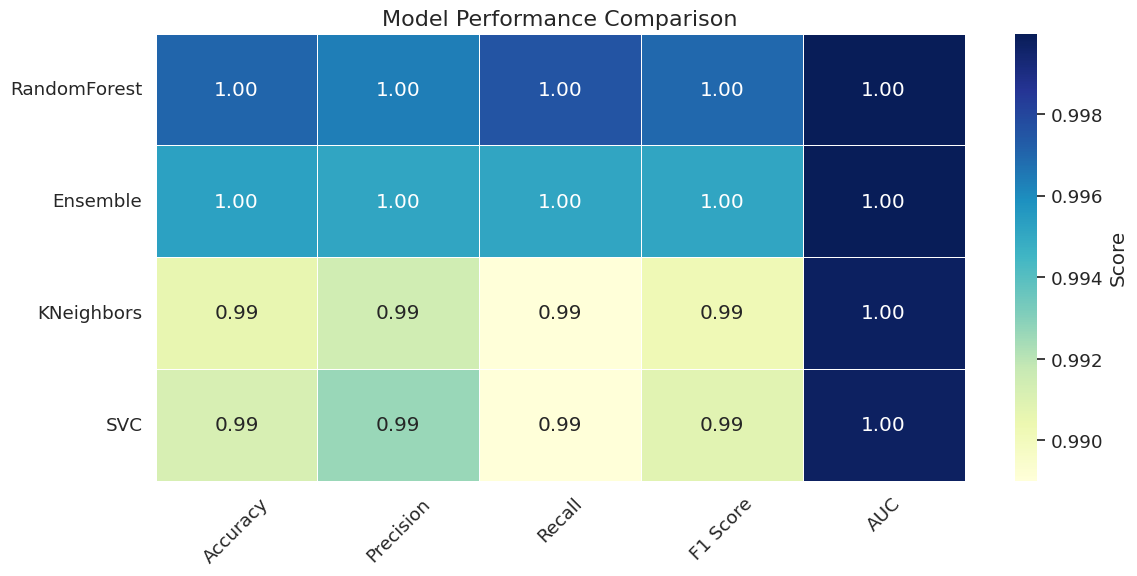

In [22]:
# Summary of Results in a well-labeled Table
summary_df = pd.DataFrame(results).T
summary_df = summary_df.sort_values(by='AUC', ascending=False)  # Sort by AUC for better comparison

# Formatting the table for better visibility
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)
ax = sns.heatmap(summary_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']], annot=True, fmt=".2f",
                 cmap="YlGnBu", cbar_kws={'label': 'Score'}, linewidths=.5)
plt.title("Model Performance Comparison", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
